In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.linear_model import LinearRegression
import seaborn as sns
from scipy.stats import t as t_distr

plt.rc('axes', axisbelow=True)

# sns.set_style("ticks",{'axes.grid' : True})
# sns.set_theme(rc={'figure.figsize':(5, 4)})

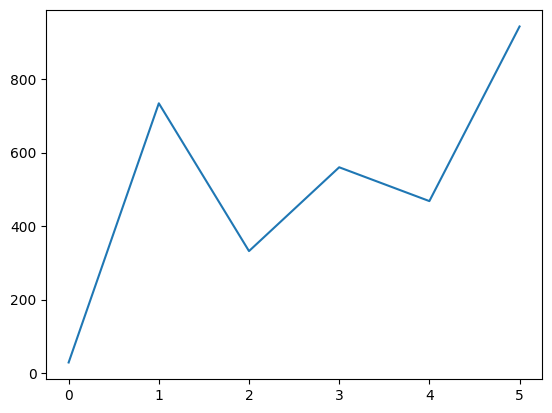

In [2]:
y = [29, 734, 332, 560, 468, 943]
plt.plot(range(0, 6), y)

In [231]:
def fround(x):
    xi = ""
    x_str = str(x)
    t = False
    for e in x_str:
        if not t:
            t = e in "123456789"
        if t:
            xi += e
    pw = 0
    if x >= 1:
        pw = x_str.find(".")
        pw = pw if pw != -1 else len(x_str)
        x_str = f"0.{x_str.replace('.', '')}"
    r = str(x_str).find(xi.replace(".", ""))
    if x_str[r + 2] == "5":  # всегда округлять x.5 вверх
        x_str = x_str[:r + 2] + "6" + x_str[r + 3:]
    if xi[0] in "123":
        return round(float(x_str), r) * 10 ** pw
    return round(float(x_str), r - 1) * 10 ** pw



In [177]:
df = pd.read_csv("measurements.csv")
df.head(5)

,lambda,r1,r2,r3,r_mean
0,546.1,1.205,1.206,1.192,1.201
1,546.1,1.463,1.465,1.478,1.469
2,546.1,1.681,1.681,1.665,1.676
3,546.1,1.861,1.867,1.857,1.862
4,435.8,1.137,1.156,1.141,1.145


#### Графики $r^2(n)$

In [178]:
def plot_radiuses(rs, lambda1, color):
    # plt.figure(figsize=(8, 6))

    rng = np.arange(0, len(rs) + 2)
    plt.scatter(rng[1:-1], rs ** 2, c="black", label=r"$\overline{r}_{n}^2$", zorder=15)

    model = LinearRegression()
    model.fit(rng[1:-1].reshape(-1, 1), (rs ** 2).to_numpy().reshape(-1, 1))
    k = model.coef_[0][0]
    intercept = model.intercept_[0]
    plt.plot(rng, k * rng + intercept, c=color, label=rf"$r^2(n)={round(k, 2)}n + {round(intercept, 2)}$", 
             zorder=5)

    plt.title("Зависимость " + r"$r^2(n)$" + " при " + rf"$\lambda={lambda1}$" + " нм")
    plt.xlabel(r"$n$", fontsize=12)
    plt.xticks(rng.astype(int))
    plt.ylabel(r"$r^2(n)$" + ", мм" + r"$^{2}$", fontsize=12)
    plt.yticks(np.arange(0, (rs ** 2).max() + k + 0.2, 0.2))
    plt.legend(fontsize=12)
    plt.grid(zorder=10)
    plt.show()

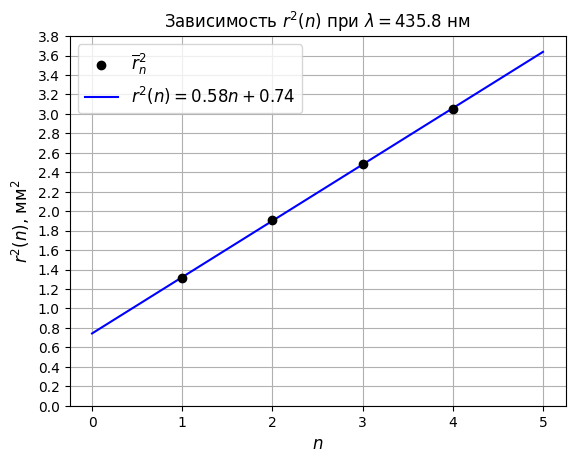

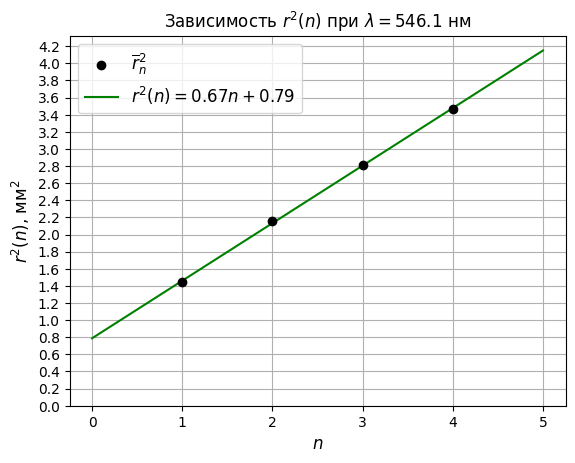

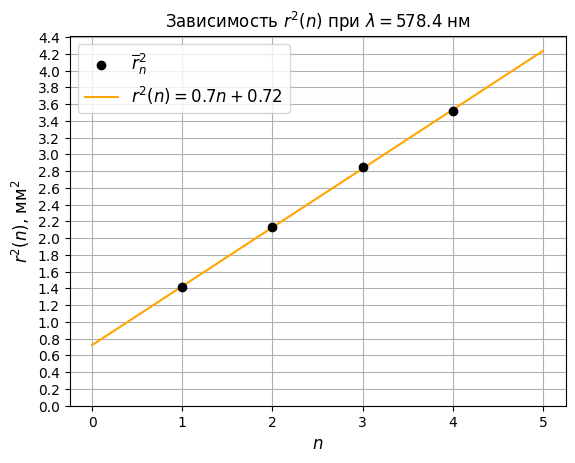

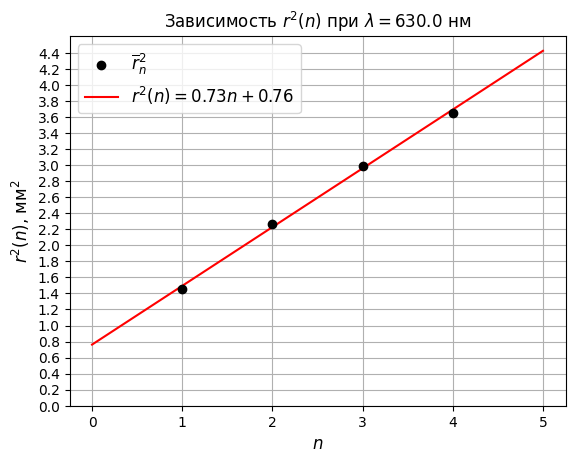

In [179]:
lambda_to_color = {
    630.0: "red",
    435.8: "blue",
    578.4: "orange",
    546.1: "green"
}

for i in df.groupby("lambda"):
    radius = i[1]["r_mean"]
    plot_radiuses(radius, i[0], lambda_to_color[i[0]])
    

#### Вычисление радиуса кривизны линзы

In [262]:
R_values = []
for lambda1, i in df.groupby("lambda"):
    r = i["r_mean"].to_numpy()
    R1 = ((r[1] ** 2 - r[0] ** 2) * 10 ** (-6)) / (lambda1 * 10 ** (-9))
    R2 = ((r[3] ** 2 - r[2] ** 2) * 10 ** (-6)) / (lambda1 * 10 ** (-9))
    # R1, R2 = fround(R1), fround(R2)
    R1, R2 = round(R1, 2), round(R2, 2)
    R_values.extend([R1, R2])

    print(*[lambda1, r[0], r[1], r[2], r[3], R1, R2], sep="\t") # R в 10^4 м
R_mean = np.mean(R_values)
R_mean

435.8	1.145	1.383	1.578	1.746	1.38	1.28
546.1	1.201	1.469	1.676	1.862	1.31	1.21
578.4	1.19	1.461	1.689	1.876	1.24	1.15
630.0	1.206	1.507	1.73	1.912	1.3	1.05


1.24

In [269]:
alpha = 0.05
R_sigma = np.sqrt(np.var(R_values) / len(R_values))
delta_R = R_sigma * t_distr.ppf(1 - alpha / 2, len(R_values) - 1)
R_error = delta_R

In [266]:
R_sigma, delta_R

(0.034186985827943356, 0.08083937575770027)

#### Доверительный интервал для $r_{disappear}$

In [270]:
alpha = 0.05
r_dis = [4.883, 5.106, 5.118, 4.280]
r_mean = np.mean(r_dis)
r_sigma = np.sqrt(np.var(r_dis) / len(r_dis))
delta_r = r_sigma * t_distr.ppf(1 - alpha / 2, len(r_dis) - 1)
r_error = delta_r

In [271]:
r_mean, delta_r

(4.84675, 0.541546068569665)

#### Пропускная способность фильтра

In [279]:
def lambda_error(lambda1, R, R_error, r, r_error):
    R = R * 10 ** 9
    R_error = R_error * 10 ** 9
    r = r * 10 ** 6
    r_error = r_error * 10 ** 6
    d_dR = (4 * lambda1 ** 2 * r ** 2) / ((lambda1 * R + 2 * r ** 2) ** 2)
    d_dr = (-8 * lambda1 ** 2 * R * r) / ((2 * r ** 2 + lambda1 * R) ** 2)
    return np.sqrt((d_dR * R_error) ** 2 + (d_dr * r_error) ** 2)


In [281]:
R = 1.24 * 10 ** 9
r = 4.85 * 10 ** 6
for lambda1, i in df.groupby("lambda"):
    delta_lambda = 2 * lambda1 ** 2 * R / (2 * r ** 2 + R * lambda1)
    print(lambda1, delta_lambda)
    print(lambda_error(lambda1, R_mean, R_error, r_mean, r_error))
    print()

435.8 9.89811468191751
2.280933780553872

546.1 15.498008866488117
3.5611176477008524

578.4 17.370958432916932
3.9881262207428647

630.0 20.581020444860766
4.718772883874834

